# Density characteristics of areas near Metro rail stations
* Policies: CA State Senate Bill 827 and Senate Bill 50 both failed in their attempts to "upzone" areas around rail stations
* What are existing housing and pop densities around Metro rail stations?
    * Look at census blocks within 0.5 mile of a rail station
    * Look at existing housing and population densities around rail stations
* Use census blocks as our "base" file, then attach information from various data sources, including:
    * American Community Survey
    * Metro station locations  
* <b> Outputs: </b>
    * (data) demo1-short.xlsx
    * (gis) demo1-short.geojson

In [1]:
pip install xlsxwriter

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import intake
import os
import geopandas as gpd
import altair.vegalite.v2 as alt
import folium
import xlsxwriter
import utils

In [3]:
cd demo/

[Errno 2] No such file or directory: 'demo/'
/home/jovyan/demo


## I. Import files
* Clip the geodataframes to LA County
* Only keep columns we need to build table

### A. Census block base (Census TIGER shapefile, 2018)

In [4]:
block = gpd.read_file('./gis/cb_2018_06_bg_500k/')

In [5]:
# Only keep LA County and project to CA State Plane
block = block[block.COUNTYFP=='037'][['GEOID', 'geometry']].to_crs({'init':'epsg:2229'})

### B. American Community Survey (ACS 5-yr 2013-2017 tabular data)
* Unit of geography: block groups in LA County
* B25001 - number of housing units
* B25008 - population by owner vs renter occupied units

In [6]:
units = pd.read_csv('./data/ACS_17_5YR_B25001_with_ann.csv')
pop = pd.read_csv('./data/ACS_17_5YR_B25008_with_ann.csv')

In [7]:
# Rename columns
units.rename(columns={'GEO.id2': 'geoid', 'HD01_VD01': 'housing_units'}, inplace=True)
pop.rename(columns={'GEO.id2': 'geoid', 'HD01_VD01': 'pop', 
                   'HD01_VD02':'owner_pop', 'HD01_VD03': 'renter_pop'}, inplace=True)

# Drop 1st row
units = units.drop(units.index[0])
pop = pop.drop(pop.index[0])

# Drop columns
units = units[['geoid', 'housing_units']]
pop = pop[['geoid', 'pop', 'owner_pop', 'renter_pop']]

In [8]:
# Change data types
units = units.astype({'geoid':'str', 'housing_units':'int32'})
pop = pop.astype({'geoid':'str', 'pop': 'int32', 'owner_pop': 'int32', 'renter_pop': 'int32'})

### C. Metro Rail Lines and Stations
* [LA Metro GIS data](https://developer.metro.net/introduction/gis-data/download-gis-data/)

In [9]:
stations = gpd.read_file('./gis/Stations_All_0316/')

In [10]:
stations = stations[['LINE', 'LINENUM', 'STOPNUM', 'geometry']].to_crs({'init':'epsg:2229'})

### Draw 0.5 mi buffer around Metro rail stations
* Any census blocks that intersect with this 0.5 mi buffer will be included in the blocks we want to map
* Tag the census blocks that overlap with the buffers

In [11]:
# All my geodataframes are in EPSG:2229, CA State Plane (units are in feet)
stations_buffer = stations
stations_buffer['geometry'] = stations_buffer.geometry.buffer(2640)

In [12]:
# Do spatial join of census blocks with station buffer. 'inner' means that those that intersect are kept in the joined df.
buffer_join = gpd.sjoin(block, stations_buffer, how='inner', op='intersects')

In [13]:
# Just keep 1 observation per census block
buffer_join = buffer_join[['GEOID']].drop_duplicates(subset = 'GEOID')

buffer_join['keep_block'] = 1

## II. Merge files at the census block level
* Use census block group as the base
* Attach ACS data 
* Attach whether block is near rail station or not

In [14]:
merge1 = pd.merge(block, units, left_on = 'GEOID', right_on = 'geoid', how='left', validate='1:1', indicator=True)
merge1.head()

,GEOID,geometry,geoid,housing_units,_merge
0,060375766021,(POLYGON ((6508302.089017047 1737063.390336079...,060375766021,1147,both
1,060371347203,"POLYGON ((6387704.357979584 1898693.448563642,...",060371347203,576,both
2,060371254023,"POLYGON ((6447020.364304705 1881120.831268478,...",060371254023,893,both
3,060375338033,"POLYGON ((6505830.883794739 1814325.136324333,...",060375338033,345,both
4,060372122042,"POLYGON ((6474107.097197829 1843873.789287847,...",060372122042,732,both


In [15]:
# Check that everything merged.
merge1['_merge'].value_counts()

both          6423
right_only       0
left_only        0
Name: _merge, dtype: int64

In [16]:
merge2 = pd.merge(merge1, pop, on='geoid', how='left')

In [17]:
merge3 = pd.merge(merge2, buffer_join, on='GEOID', how='left')

## III. Assemble dataset of census blocks with all the information attached

In [18]:
# This is our "final" dataframe 
gdf = merge3.copy()
gdf = gdf.drop(columns=['_merge', 'geoid'])
gdf.head()

,GEOID,geometry,housing_units,pop,owner_pop,renter_pop,keep_block
0,060375766021,(POLYGON ((6508302.089017047 1737063.390336079...,1147,1676,444,1232,NaN
1,060371347203,"POLYGON ((6387704.357979584 1898693.448563642,...",576,1253,438,815,NaN
2,060371254023,"POLYGON ((6447020.364304705 1881120.831268478,...",893,1901,257,1644,NaN
3,060375338033,"POLYGON ((6505830.883794739 1814325.136324333,...",345,1289,444,845,NaN
4,060372122042,"POLYGON ((6474107.097197829 1843873.789287847,...",732,1932,100,1832,1.0


### Normalize by area

In [19]:
gdf['acres'] = gdf.geometry.area / utils.feet_in_acres

for col in ['housing_units', 'pop']:
    new_col = f"{col}_acre"
    gdf[new_col] = gdf[col] / gdf.acres

In [20]:
gdf = gdf[gdf.keep_block == 1]
gdf.head()

,GEOID,geometry,housing_units,pop,owner_pop,renter_pop,keep_block,acres,housing_units_acre,pop_acre
4,060372122042,"POLYGON ((6474107.097197829 1843873.789287847,...",732,1932,100,1832,1.0,14.898943,49.131002,129.673627
6,060372094031,"POLYGON ((6478507.520417627 1842668.155661697,...",787,1629,0,1629,1.0,17.494330,44.986004,93.115883
7,060375327001,"POLYGON ((6486564.571323734 1818650.980400814,...",363,1567,480,1087,1.0,62.610415,5.797757,25.027785
9,060372117032,"POLYGON ((6466547.774524551 1847625.203366093,...",898,1939,385,1554,1.0,22.762982,39.450015,85.182160
15,060372220021,"POLYGON ((6465418.791555855 1831829.104294554,...",483,1473,510,963,1.0,41.324583,11.687958,35.644643


## IV. Visualize

In [21]:
housing = gdf[['GEOID', 'housing_units_acre']]

bins = list(housing['housing_units_acre'].quantile([0, 0.25, 0.5, 0.75, 1]))

m = folium.Map(
    location=[34.0536, -118.2427], 
    zoom_start=12, 
    tiles='cartodbpositron'
)


# Add the color for the chloropleth:
m.choropleth(
    geo_data=gdf[['GEOID', 'geometry']],
    name = 'choropleth',
    data=housing,
    columns=['GEOID', 'housing_units_acre'],
    key_on='feature.properties.GEOID',
    fill_color='BuPu',
    fill_opacity=0.95,
    line_opacity=0.8, line_color='#ffffff',
    bins=bins,
    legend_name='Housing Units per Acre'
)

folium.LayerControl().add_to(m)

m

/opt/conda/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


#### Export as GeoJSON

In [22]:
"""
gdf.to_file(driver = 'GeoJSON', filename = './gis/demo1-short.geojson')
"""

"\ngdf.to_file(driver = 'GeoJSON', filename = './gis/demo1-short.geojson')\n"

#### Export tables to Excel

In [23]:
subset = ['housing_units', 'pop', 'owner_pop', 'renter_pop', 'housing_units_acre', 'pop_acre']
summary = gdf[subset].describe()
summary

,housing_units,pop,owner_pop,renter_pop,housing_units_acre,pop_acre
count,924.000000,924.000000,924.000000,924.000000,924.000000,924.000000
mean,587.070346,1511.412338,436.936147,1074.476190,12.534514,31.638994
std,367.284171,720.597895,386.311049,711.242927,12.960340,27.680355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,349.750000,979.250000,123.000000,559.750000,4.766396,13.530716
50%,499.000000,1397.500000,344.500000,944.000000,8.241593,24.669798
75%,725.500000,1936.750000,669.000000,1481.500000,14.882577,40.298447
max,3245.000000,4675.000000,3060.000000,4031.000000,128.616616,183.616188


In [24]:
"""
# Create a pandas Excel writer using xlsxWriter as the engine.
writer = pd.ExcelWriter('./data/demo1-short.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
df2.to_excel(writer, sheet_name='data')
summary.to_excel(writer, sheet_name='summary stats')

writer.save()
"""

"\n# Create a pandas Excel writer using xlsxWriter as the engine.\nwriter = pd.ExcelWriter('./data/demo1-short.xlsx', engine='xlsxwriter')\n\n# Write each dataframe to a different worksheet.\ndf2.to_excel(writer, sheet_name='data')\nsummary.to_excel(writer, sheet_name='summary stats')\n\nwriter.save()\n"

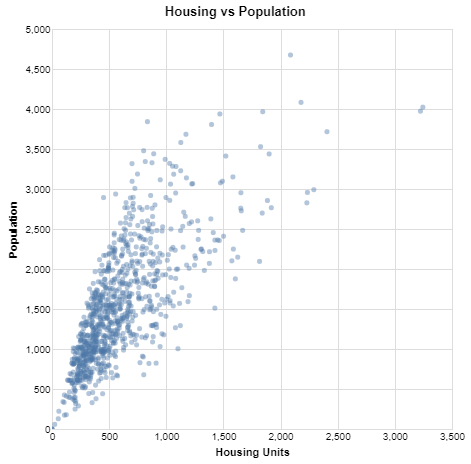

In [25]:
# Drop geometry column because Altair can't use geodataframes
df2 = gdf.drop(columns='geometry')

# Make scatterplot
scatter = alt.Chart(df2).mark_circle(size=25, fillOpacity=0.6).encode(
    x='housing_units:Q',
    y='pop:Q',
).interactive()

scatter.encoding.x.title= 'Housing Units'
scatter.encoding.y.title = 'Population'

alt.layer(scatter).configure_view(
    strokeOpacity=0, strokeWidth=0).configure(
    countTitle=' ').configure_scale(
    bandPaddingInner=0.2
    ).configure_axis(
    grid=True, ticks=False, labelAngle=0, domainWidth=0).configure_axisY(
    labelColor='black').properties(
    height=400, width=400, title='Housing vs Population')